In [27]:
import tensorflow as tf
from tensorflow.python.data import Dataset
import pandas as pd
import numpy as np
% matplotlib inline

import math

from IPython import display
from matplotlib import cm, gridspec
import matplotlib.pyplot as plt

from sklearn import metrics


In [28]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows=9
pd.options.display.float_format = '{:.1f}'.format

In [3]:
pd.__version__

'0.22.0'

In [4]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efd44795390>]],
      dtype=object)

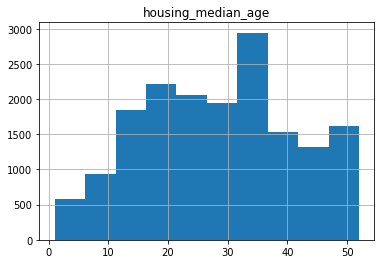

In [8]:
california_housing_dataframe.hist('housing_median_age')

In [9]:
city_names = pd.Series(['San Francisco', 'San Jose', 'Sacramento'])
population = pd.Series([852469, 1015785, 485199])

pd.DataFrame({ 'City name': city_names, 'Population': population })
cities = pd.DataFrame({ 'City name': city_names, 'Population': population })

In [10]:
cities['Area square miles'] = pd.Series([46.87, 176.53, 97.92])
cities['Population density'] = cities['Population'] / cities['Area square miles']

In [18]:
cities['ble'] = cities.apply(lambda x: x['City name'].startswith('San') & (x['Area square miles']>50), axis=1)

In [19]:
cities

,City name,Population,Area square miles,Population density,,ble
0,San Francisco,852469,46.87,18187.945381,True,False
1,San Jose,1015785,176.53,5754.177760,True,True
2,Sacramento,485199,97.92,4955.055147,False,False


In [25]:
cities.reindex([3,6,5])

,City name,Population,Area square miles,Population density,,ble
3,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
cities

,City name,Population,Area square miles,Population density,,ble
0,San Francisco,852469,46.87,18187.945381,True,False
1,San Jose,1015785,176.53,5754.177760,True,True
2,Sacramento,485199,97.92,4955.055147,False,False


In [30]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

In [31]:
california_housing_dataframe['median_house_value'] /= 1000

In [33]:
my_feature = california_housing_dataframe[["total_rooms"]]

In [35]:
feature_columns = [tf.feature_column.numeric_column('total_rooms')]

In [37]:
targets = california_housing_dataframe['median_house_value']

In [38]:
optimiser = tf.train.GradientDescentOptimizer(learning_rate=.0001)
optimiser = tf.contrib.estimator.clip_gradients_by_norm(optimiser, 5.0)

In [40]:
linRegressor = tf.estimator.LinearRegressor(feature_columns=feature_columns, optimizer=optimiser)

In [159]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
      """
    
    features = {key: np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels
        
    

In [186]:
t_f, t_l = my_input_fn(my_feature, targets)

In [197]:
tnsr = t_f['total_rooms']

In [200]:
tnsr.

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [160]:
_ = linRegressor.train(
    input_fn=lambda: my_input_fn(my_feature, targets),
    steps=100)

In [162]:
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

In [180]:
predictions = linRegressor.predict(input_fn=prediction_input_fn)

In [181]:
predictions = [item['predictions'][0] for item in predictions]

In [182]:
mse = metrics.mean_squared_error(targets, predictions)

In [184]:
rmse = math.sqrt(mse)

In [185]:
rmse

168.84043923161718